In [1]:
import pandas as pd
from urllib.request import Request, urlopen
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
import time
import sys
import re
import seaborn as sns
import gc
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import math
import tensorflow as tf
pd.set_option('display.max_rows', None)

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-11-13 16:11:38.912770: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 16:11:38.977652: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 16:11:38.977843: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [38]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [39]:
df=pd.read_csv('gdrive/My Drive/vol_10mins_furtherpreprocess.csv').fillna(0)
df['tx_timestamp'] = pd.to_datetime(df['tx_timestamp'],unit='ns')
df = df.rename(columns = {"tx_timestamp":"timestamp","0":"volatility"})
display(df.head(3))
df.tail()

,timestamp,volatility
0,2020-05-26 21:00:00+00:00,0.0
1,2020-05-26 21:10:00+00:00,0.0
2,2020-05-26 21:20:00+00:00,0.0


,timestamp,volatility
127685,2022-10-30 13:50:00+00:00,0.007068
127686,2022-10-30 14:00:00+00:00,0.007478
127687,2022-10-30 14:10:00+00:00,0.006892
127688,2022-10-30 14:20:00+00:00,0.008923
127689,2022-10-30 14:30:00+00:00,0.006163


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127690 entries, 0 to 127689
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype              
---  ------      --------------   -----              
 0   timestamp   127690 non-null  datetime64[ns, UTC]
 1   volatility  127690 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 1.9 MB


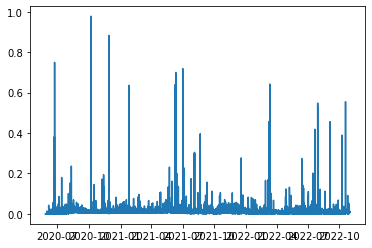

In [ ]:
plt.plot(df['timestamp'],df['volatility'])

In [ ]:
df.shape

(127690, 2)

### MLP

In [41]:
train_start = '2020-05-26'
train_end = '2022-07-31'
dev_start = '2022-08-01'
dev_end = '2022-09-30'
test_start = '2022-10-01'
test_end = '2022-10-31'

In [64]:
train_dates = df[((df['timestamp'] >= train_start) & (df['timestamp'] <= train_end))]['volatility'].values.reshape((-1,1))
dev_dates = df[((df['timestamp'] >= dev_start) & (df['timestamp'] <= dev_end))]['volatility'].values.reshape((-1,1))
test_dates = df[((df['timestamp'] >= test_start) & (df['timestamp'] <= test_end))]['volatility'].values.reshape((-1,1))
train_dates.shape, dev_dates.shape, test_dates.shape

((114499, 1), (8641, 1), (4264, 1))

In [82]:
# univariate mlp example
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
raw_seq = train_dates
# choose a number of time steps
days_look_back = 14
n_steps = 24*6*days_look_back
# split into samples
X, y = split_sequence(raw_seq, n_steps)

# define model
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=n_steps))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss=tf.keras.losses.MeanAbsolutePercentageError())

# fit model
num_epochs = 50
history = model.fit(X, y, epochs=num_epochs)

Epoch 1/50
3516/3516 [==============================] - 21s 6ms/step - loss: 27988.4473
Epoch 2/50
3516/3516 [==============================] - 18s 5ms/step - loss: 12400.3750
Epoch 3/50
3516/3516 [==============================] - 22s 6ms/step - loss: 12666.0693
Epoch 4/50
3516/3516 [==============================] - 19s 5ms/step - loss: 12490.8838
Epoch 5/50
3516/3516 [==============================] - 19s 5ms/step - loss: 12076.5674
Epoch 6/50
3516/3516 [==============================] - 19s 5ms/step - loss: 12535.7568
Epoch 7/50
3516/3516 [==============================] - 17s 5ms/step - loss: 11722.0762
Epoch 8/50
3516/3516 [==============================] - 17s 5ms/step - loss: 13383.4600
Epoch 9/50
3516/3516 [==============================] - 18s 5ms/step - loss: 13320.6709
Epoch 10/50
3516/3516 [==============================] - 17s 5ms/step - loss: 10035.7041
Epoch 11/50
3516/3516 [==============================] - 18s 5ms/step - loss: 11900.1387
Epoch 12/50
3516/3516 [=======

In [83]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 128)               258176    
                                                                 
 dense_21 (Dense)            (None, 64)                8256      
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 266,497
Trainable params: 266,497
Non-trainable params: 0
_________________________________________________________________


In [84]:
model_save_name = 'MLP128_64_baseline_ep50_back14'
model.save('/content/gdrive/My Drive/CS230proj/model_{}.h5'.format(model_save_name))

In [72]:
#import tensorflow as tf
#from tensorflow import keras
#new_model = tf.keras.models.load_model('/content/gdrive/My Drive/CS230proj/model_{}.h5'.format(model_save_name))

# Check its architecture
#new_model.summary()

In [85]:
# demonstrate prediction
X_dev, y_dev = split_sequence(dev_dates, n_steps)
X_dev = X_dev.reshape((X_dev.shape[0], n_steps))
y_dev_pred = model.predict(X_dev)
y_train_pred = model.predict(X.reshape((X.shape[0], n_steps)))
print(y_dev_pred.shape, y_train_pred.shape)

3516/3516 [==============================] - 30s 9ms/step
(6625, 1) (112483, 1)


In [86]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_dev_pred, dev_dates[24*6*days_look_back:])

204.80800554337532

In [87]:
mean_absolute_percentage_error(y_train_pred, train_dates[24*6*days_look_back:])

244.8658270834014